In [1]:
# Import MNIST dataset
# Generate empirical graph with 1 cluster
# For n in [2,4,10,20,40,100,200] or similar...
#   Divide the data
#   Initialize commonly the models
#   Run our algorithm
# First centralized, then noncentralized (the same thing for us?)
# Compare the result with global single converer (with wall time the same)

# Training loss / test loss for every lambda = 0,0.1,1,10...

# Take a single lambda and vary the connection probability p

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
from graspologic.simulations import sbm
from itertools import cycle
%config InlineBackend.figure_format = 'retina'
DEVICE = "cuda" # or "cpu"
from tqdm.notebook import tqdm

# Load and normalize MNIST data

In [3]:
#Download the datasets
dataset_train = torchvision.datasets.MNIST('../data', train=True, download=True,transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('../data', train=False, download=True,transform=torchvision.transforms.ToTensor())
# For normalization, get mean and std of the training dataset
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train))
data = next(iter(train_loader))[0]
mean, std = data.mean().item(), data.std().item()
print("Mean pixel is",mean," and std is",std)

# Now we can load the dataset with normalizing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,),(std,))
])
dataset_train.transform = transform
dataset_test.transform = transform

Mean pixel is 0.13066047430038452  and std is 0.30810782313346863


6


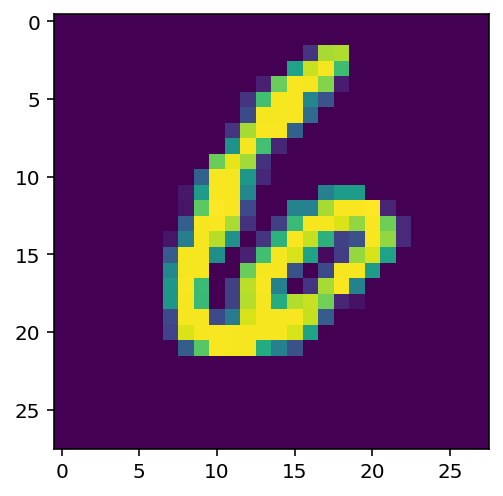

In [4]:
def showimg(tensor):
    plt.imshow(tensor.reshape(28,28))
showimg(dataset_train[13][0]); # plt.imshow does a min-max normalization, so it always looks the same
print(dataset_train[13][1])

# Generating the empirical graph

In [5]:
# Return the adjacency matrix (as numpy.ndarray), where elements are the link strengths
def getAfromSBM(n=10, p=0.5, mu=1):
    n = [n]
    p = [[p]]
    wt = [[np.random.normal]]
    wtargs = [[dict(loc=mu, scale=0)]] # scale=1 would be gaussian
    A = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    return A

A = getAfromSBM()

# Define the model and data setup

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
def sizes(num,div):
    return [num // div + (1 if x < num % div else 0) for x in range(div)]

def initialize_learners(n_learners=10):
    # divide the data evenly to n_learners
    dataset_sizes = sizes(60000, n_learners)
    datasets = torch.utils.data.random_split(dataset_train,dataset_sizes)
    dataloaders = [torch.utils.data.DataLoader(datasets[i], batch_size = 256) for i in range(n_learners)]
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

    # Initialize the models
    models = [Net().to(DEVICE) for i in range(n_learners)]
    
    # Copy the initialization from model 1 to all others
    # NOTE: THIS CAUSES HARD-TO-TRACK BUGS! THE PARAMETERS ARE REF-SHARED
    #init_theta1 = torch.nn.utils.parameters_to_vector(models[0].parameters()).detach()
    #for i in range(1,n_learners):
    #    torch.nn.utils.vector_to_parameters(init_theta1, models[i].parameters())
        
    # Version 2 for initialization
    for i in range(1,n_learners):
        models[i].load_state_dict(models[0].state_dict())
        
    return dataloaders, testloader, models

def L2(local, neighbor):
    return torch.norm(local - neighbor)

def L2_squared(local, neighbor):
    #return torch.norm(local - neighbor).pow(2)
    return (local - neighbor).pow(2).sum()

# Define the local training step and the testing procedure

In [8]:
# Takes a single optimizer step. Note that the optimizer state is updated.
def train_single_step(model, dataiter, optimizer, neighbor_thetas, neighbor_weights, lambd=0, g=L2_squared):
    model.train() # Change into training mode (matters for dropout, at least)
    data, target = next(dataiter)
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    # First, compute the local loss
    output = model(data)
    loss = F.nll_loss(output, target)
    # Then add the parameter differences
    local_theta = torch.nn.utils.parameters_to_vector(model.parameters())
    for i in range(len(neighbor_thetas)):
        loss += lambd * neighbor_weights[i] * g(local_theta,neighbor_thetas[i])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [9]:
def test(model, testloader, verbose=True):
    model.eval() #Change to evalution mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output=model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum of the batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct guesses
    test_loss /= len(testloader.dataset) # Mean loss (divided by the size of the whole test set)
    
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader.dataset), 100. * correct / len(testloader.dataset)))
    # Return both loss value and test accuracy
    return test_loss, correct / len(testloader.dataset)

In [10]:
def compute_L(models, dataloaders, testloader, A, lambd=0, g=L2_squared):
    L_loss = 0
    L_reg = 0
    with torch.no_grad():
        for i in range(len(models)):
            models[i].eval()
            loss, _ = test(models[i], dataloaders[i], verbose=False)
            L_loss += loss
            neighbor_indices = np.nonzero(A[i])[0]
            local_theta = torch.nn.utils.parameters_to_vector(models[i].parameters())
            for index in neighbor_indices:
                neighbor_theta = torch.nn.utils.parameters_to_vector(models[index].parameters()).detach()
                L_reg += 0.5 * lambd * A[i][index] * g(local_theta, neighbor_theta).item()
                # 0.5 because each edge is counted twice this way
    return L_loss, L_reg

def print_memory():
    print("Total:",torch.cuda.get_device_properties(0).total_memory)
    print("Allocated:",torch.cuda.memory_allocated(0))
    print("Reserved:",torch.cuda.memory_allocated(0))

# Define the optimization algorithm

In [11]:
def run_experiment(n_learners=100, n_iterations=1000,lambd=0,last_only=False, compute_L_flag=False, verbose=False, p=0.5, g=L2_squared):
    
    A = getAfromSBM(n_learners, p, 1)
    dataloaders, testloader, models = initialize_learners(n_learners)
    
    # Create optimizers to hold the state of one model
    optimizers = [torch.optim.Adam(models[i].parameters()) for i in range(n_learners)]
    # note that the optimizers only start holding memory-heavy state after the first step. This is 
    # why it looks like a memory leak during the training (when k is chosen randomly)
    
    # Load batches infinitely in the same cycle (could update to resample a new loader after one epoch, but this is ok.)
    dataiters = [cycle(dataloader) for dataloader in dataloaders]
    
    results = []
    k = 0
    for i in tqdm(range(n_iterations+1)):
        # Choose a random learner (single one for now)
        k = random.randrange(n_learners)
        # Work out all the neighbors and the model states of the neighbors
        neighbor_indices = np.nonzero(A[k])[0]
        neighbor_weights = A[k][neighbor_indices]
        neighbor_thetas = []
        for index in neighbor_indices:
            # Transform the models[index] parameters into a plain vector. Note that we detach them here: this way
            # no gradient is sent to neighbor thetas.
            neighbor_thetas.append(torch.nn.utils.parameters_to_vector(models[index].parameters()).detach())

        # Take the local step except on the very first one (to have correct amount of timepoints)
        if i != 0: train_single_step(models[k], dataiters[k], optimizers[k], neighbor_thetas, neighbor_weights, lambd, g=g)

        # At some timepoints, calculate losses and accuracies and add to results
        # If last_only is True, then only do this at the last timestep.
        if ((not last_only) and i % 100 == 0) or (last_only and i == n_iterations-1):
            if verbose: print("Iteration",i,":")
            train_loss, train_accuracy = test(models[0], dataloaders[0])
            test_loss, test_accuracy = test(models[0], testloader)
            if compute_L_flag:
                L_loss, L_reg = compute_L(models, dataloaders, testloader, A, lambd, g=g)
            else:
                L_loss, L_reg = 0, 0
            results.append((train_loss, train_accuracy, test_loss, test_accuracy,L_loss, L_reg))
    return results

# Run the optimization with lambda=1, see if local loss, test loss, and whole L converge

In [19]:
results = run_experiment(60, 10000, 1, last_only=False, compute_L_flag=True, verbose=True)
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]
L_losses = list(zip(*results))[4]
L_regs = list(zip(*results))[5]

Iteration 0 :

Test set: Average loss: 2.3021, Accuracy: 94/1000 (9%)


Test set: Average loss: 2.3033, Accuracy: 1018/10000 (10%)

Iteration 100 :

Test set: Average loss: 2.0916, Accuracy: 292/1000 (29%)


Test set: Average loss: 2.0882, Accuracy: 3054/10000 (31%)

Iteration 200 :

Test set: Average loss: 2.1435, Accuracy: 653/1000 (65%)


Test set: Average loss: 2.1398, Accuracy: 6520/10000 (65%)

Iteration 300 :

Test set: Average loss: 2.1168, Accuracy: 640/1000 (64%)


Test set: Average loss: 2.1119, Accuracy: 6499/10000 (65%)

Iteration 400 :

Test set: Average loss: 1.9946, Accuracy: 674/1000 (67%)


Test set: Average loss: 1.9863, Accuracy: 6909/10000 (69%)

Iteration 500 :

Test set: Average loss: 1.8217, Accuracy: 674/1000 (67%)


Test set: Average loss: 1.8084, Accuracy: 6978/10000 (70%)

Iteration 600 :

Test set: Average loss: 1.4597, Accuracy: 716/1000 (72%)


Test set: Average loss: 1.4339, Accuracy: 7380/10000 (74%)

Iteration 700 :

Test set: Average loss: 1.2808, Acc

Iteration 6000 :

Test set: Average loss: 0.2857, Accuracy: 921/1000 (92%)


Test set: Average loss: 0.2497, Accuracy: 9283/10000 (93%)

Iteration 6100 :

Test set: Average loss: 0.2801, Accuracy: 921/1000 (92%)


Test set: Average loss: 0.2450, Accuracy: 9293/10000 (93%)

Iteration 6200 :

Test set: Average loss: 0.2801, Accuracy: 921/1000 (92%)


Test set: Average loss: 0.2450, Accuracy: 9293/10000 (93%)

Iteration 6300 :

Test set: Average loss: 0.2690, Accuracy: 928/1000 (93%)


Test set: Average loss: 0.2352, Accuracy: 9315/10000 (93%)

Iteration 6400 :

Test set: Average loss: 0.2636, Accuracy: 929/1000 (93%)


Test set: Average loss: 0.2303, Accuracy: 9337/10000 (93%)

Iteration 6500 :

Test set: Average loss: 0.2636, Accuracy: 929/1000 (93%)


Test set: Average loss: 0.2303, Accuracy: 9337/10000 (93%)

Iteration 6600 :

Test set: Average loss: 0.2599, Accuracy: 931/1000 (93%)


Test set: Average loss: 0.2270, Accuracy: 9345/10000 (93%)

Iteration 6700 :

Test set: Average loss:

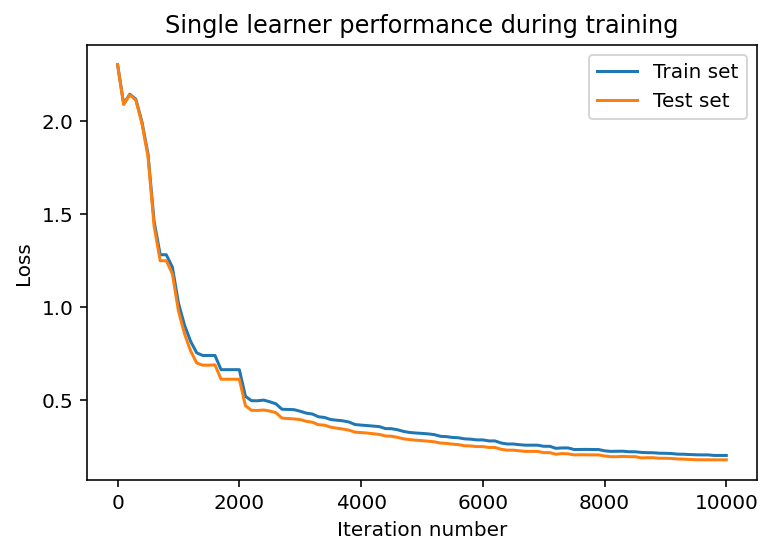

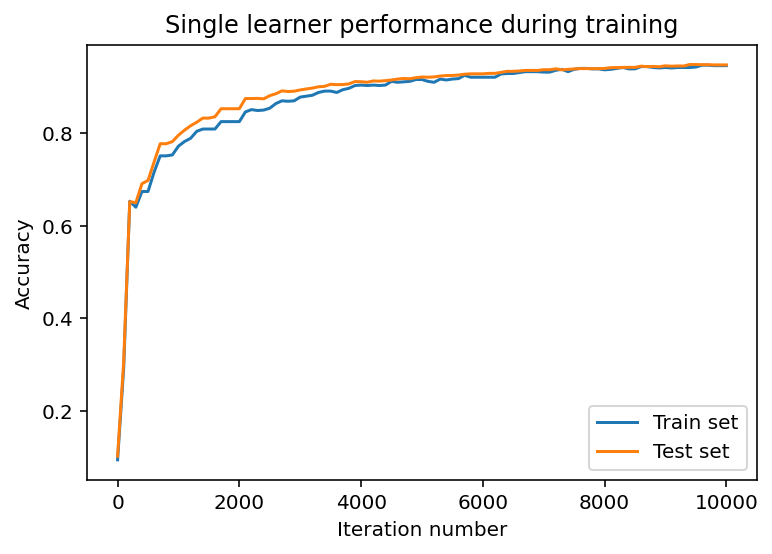

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


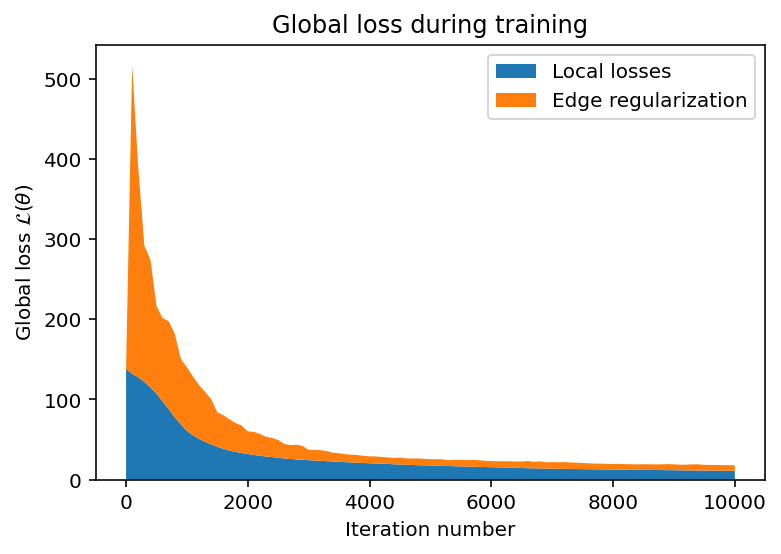

In [20]:
plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_losses,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_losses,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_accuracies,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_accuracies,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.stackplot(range(0,100*len(train_losses),100), L_losses, L_regs, labels=["Local losses", "Edge regularization"])
plt.title("Global loss during training")
plt.ylabel(r"Global loss $\mathcal{L}(\theta)$")
plt.xlabel("Iteration number")
plt.legend()

# Vary the lambda

In [19]:
# Run for different choices of lambd
lambdas = np.logspace(-5,1,30) # From 0.001 to 100

In [20]:
results = []
for lambd in tqdm(lambdas):
    print("Starting the run with lambda=",lambd)
    subresults = run_experiment(60, 5000, lambd, True)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))

Starting the run with lambda= 1e-05



Test set: Average loss: 0.0110, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.1908, Accuracy: 9473/10000 (95%)


Starting the run with lambda= 1.610262027560939e-05



Test set: Average loss: 0.0057, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.2258, Accuracy: 9427/10000 (94%)


Starting the run with lambda= 2.592943797404667e-05



Test set: Average loss: 0.0079, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.2094, Accuracy: 9455/10000 (95%)


Starting the run with lambda= 4.1753189365604006e-05



Test set: Average loss: 0.0059, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.2242, Accuracy: 9464/10000 (95%)


Starting the run with lambda= 6.723357536499335e-05



Test set: Average loss: 0.0118, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.1891, Accuracy: 9459/10000 (95%)


Starting the run with lambda= 0.00010826367338740541



Test set: Average loss: 0.0060, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.1880, Accuracy: 9492/10000 (95%)


Starting the run with lambda= 0.00017433288221999874



Test set: Average loss: 0.0091, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.1820, Accuracy: 9501/10000 (95%)


Starting the run with lambda= 0.0002807216203941176



Test set: Average loss: 0.0095, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.1725, Accuracy: 9541/10000 (95%)


Starting the run with lambda= 0.00045203536563602405



Test set: Average loss: 0.0133, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.1680, Accuracy: 9563/10000 (96%)


Starting the run with lambda= 0.0007278953843983146



Test set: Average loss: 0.0290, Accuracy: 993/1000 (99%)


Test set: Average loss: 0.1257, Accuracy: 9637/10000 (96%)


Starting the run with lambda= 0.0011721022975334804



Test set: Average loss: 0.0245, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.1294, Accuracy: 9598/10000 (96%)


Starting the run with lambda= 0.0018873918221350976



Test set: Average loss: 0.0302, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.1313, Accuracy: 9599/10000 (96%)


Starting the run with lambda= 0.0030391953823131978



Test set: Average loss: 0.0388, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.1027, Accuracy: 9685/10000 (97%)


Starting the run with lambda= 0.004893900918477494



Test set: Average loss: 0.0523, Accuracy: 986/1000 (99%)


Test set: Average loss: 0.0962, Accuracy: 9702/10000 (97%)


Starting the run with lambda= 0.007880462815669913



Test set: Average loss: 0.0620, Accuracy: 983/1000 (98%)


Test set: Average loss: 0.0986, Accuracy: 9692/10000 (97%)


Starting the run with lambda= 0.01268961003167922



Test set: Average loss: 0.0757, Accuracy: 979/1000 (98%)


Test set: Average loss: 0.0975, Accuracy: 9695/10000 (97%)


Starting the run with lambda= 0.020433597178569417



Test set: Average loss: 0.0623, Accuracy: 983/1000 (98%)


Test set: Average loss: 0.1034, Accuracy: 9683/10000 (97%)


Starting the run with lambda= 0.03290344562312668



Test set: Average loss: 0.0885, Accuracy: 976/1000 (98%)


Test set: Average loss: 0.1000, Accuracy: 9688/10000 (97%)


Starting the run with lambda= 0.05298316906283707



Test set: Average loss: 0.1332, Accuracy: 962/1000 (96%)


Test set: Average loss: 0.1290, Accuracy: 9601/10000 (96%)


Starting the run with lambda= 0.08531678524172806



Test set: Average loss: 0.1374, Accuracy: 955/1000 (96%)


Test set: Average loss: 0.1431, Accuracy: 9573/10000 (96%)


Starting the run with lambda= 0.1373823795883264



Test set: Average loss: 0.1721, Accuracy: 953/1000 (95%)


Test set: Average loss: 0.1691, Accuracy: 9490/10000 (95%)


Starting the run with lambda= 0.22122162910704501



Test set: Average loss: 0.1760, Accuracy: 962/1000 (96%)


Test set: Average loss: 0.1856, Accuracy: 9441/10000 (94%)


Starting the run with lambda= 0.35622478902624444



Test set: Average loss: 0.1830, Accuracy: 938/1000 (94%)


Test set: Average loss: 0.2096, Accuracy: 9363/10000 (94%)


Starting the run with lambda= 0.5736152510448681



Test set: Average loss: 0.2567, Accuracy: 921/1000 (92%)


Test set: Average loss: 0.2373, Accuracy: 9302/10000 (93%)


Starting the run with lambda= 0.9236708571873865



Test set: Average loss: 0.2856, Accuracy: 917/1000 (92%)


Test set: Average loss: 0.2849, Accuracy: 9166/10000 (92%)


Starting the run with lambda= 1.4873521072935119



Test set: Average loss: 0.3171, Accuracy: 915/1000 (92%)


Test set: Average loss: 0.2843, Accuracy: 9190/10000 (92%)


Starting the run with lambda= 2.395026619987486



Test set: Average loss: 0.4056, Accuracy: 896/1000 (90%)


Test set: Average loss: 0.3792, Accuracy: 8980/10000 (90%)


Starting the run with lambda= 3.856620421163472



Test set: Average loss: 0.4724, Accuracy: 886/1000 (89%)


Test set: Average loss: 0.4589, Accuracy: 8883/10000 (89%)


Starting the run with lambda= 6.2101694189156165



Test set: Average loss: 0.5282, Accuracy: 863/1000 (86%)


Test set: Average loss: 0.5101, Accuracy: 8709/10000 (87%)


Starting the run with lambda= 10.0



Test set: Average loss: 1.9846, Accuracy: 670/1000 (67%)


Test set: Average loss: 1.9728, Accuracy: 6799/10000 (68%)





In [21]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9473
The best accuracy is 0.9702 , achieved by lambda= 0.004893900918477494


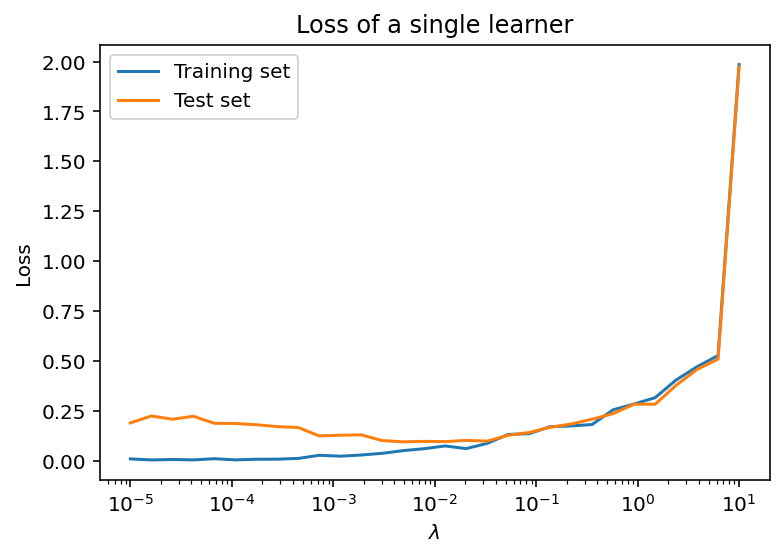

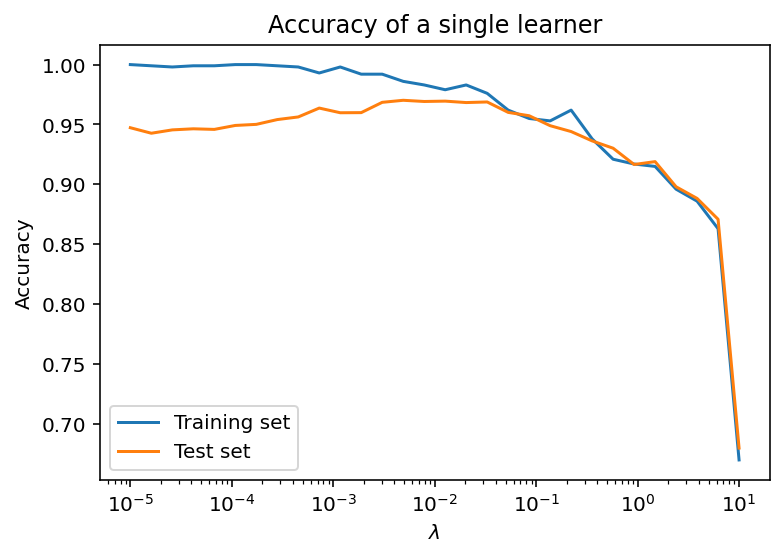

In [22]:
# 50 learners learning with ADAM and L2 norm for 5000 steps. The end state for a single learner.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Keep lambda constant, vary the connection probability

In [12]:
lambd = 0.01
results = []
ps = np.linspace(0,1,25)
for p in tqdm(ps):
    print("Starting the run with p=",p)
    subresults = run_experiment(60, 10000, lambd, last_only=True, compute_L_flag=False, verbose=False, p=p)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))

Starting the run with p= 0.0



Test set: Average loss: 0.0007, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2545, Accuracy: 9457/10000 (95%)


Starting the run with p= 0.041666666666666664



Test set: Average loss: 0.0018, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.1234, Accuracy: 9678/10000 (97%)


Starting the run with p= 0.08333333333333333



Test set: Average loss: 0.0151, Accuracy: 996/1000 (100%)


Test set: Average loss: 0.0547, Accuracy: 9833/10000 (98%)


Starting the run with p= 0.125



Test set: Average loss: 0.0116, Accuracy: 997/1000 (100%)


Test set: Average loss: 0.0690, Accuracy: 9786/10000 (98%)


Starting the run with p= 0.16666666666666666



Test set: Average loss: 0.0209, Accuracy: 990/1000 (99%)


Test set: Average loss: 0.0568, Accuracy: 9822/10000 (98%)


Starting the run with p= 0.20833333333333331



Test set: Average loss: 0.0168, Accuracy: 995/1000 (100%)


Test set: Average loss: 0.0560, Accuracy: 9808/10000 (98%)


Starting the run with p= 0.25



Test set: Average loss: 0.0158, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.0538, Accuracy: 9830/10000 (98%)


Starting the run with p= 0.29166666666666663



Test set: Average loss: 0.0258, Accuracy: 995/1000 (100%)


Test set: Average loss: 0.0590, Accuracy: 9803/10000 (98%)


Starting the run with p= 0.3333333333333333



Test set: Average loss: 0.0233, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0603, Accuracy: 9804/10000 (98%)


Starting the run with p= 0.375



Test set: Average loss: 0.0283, Accuracy: 995/1000 (100%)


Test set: Average loss: 0.0568, Accuracy: 9809/10000 (98%)


Starting the run with p= 0.41666666666666663



Test set: Average loss: 0.0337, Accuracy: 988/1000 (99%)


Test set: Average loss: 0.0583, Accuracy: 9806/10000 (98%)


Starting the run with p= 0.4583333333333333



Test set: Average loss: 0.0230, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0556, Accuracy: 9806/10000 (98%)


Starting the run with p= 0.5



Test set: Average loss: 0.0299, Accuracy: 994/1000 (99%)


Test set: Average loss: 0.0567, Accuracy: 9817/10000 (98%)


Starting the run with p= 0.5416666666666666



Test set: Average loss: 0.0521, Accuracy: 985/1000 (98%)


Test set: Average loss: 0.0534, Accuracy: 9833/10000 (98%)


Starting the run with p= 0.5833333333333333



Test set: Average loss: 0.0317, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0538, Accuracy: 9812/10000 (98%)


Starting the run with p= 0.625



Test set: Average loss: 0.0261, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0571, Accuracy: 9822/10000 (98%)


Starting the run with p= 0.6666666666666666



Test set: Average loss: 0.0431, Accuracy: 988/1000 (99%)


Test set: Average loss: 0.0553, Accuracy: 9825/10000 (98%)


Starting the run with p= 0.7083333333333333



Test set: Average loss: 0.0269, Accuracy: 994/1000 (99%)


Test set: Average loss: 0.0529, Accuracy: 9825/10000 (98%)


Starting the run with p= 0.75



Test set: Average loss: 0.0264, Accuracy: 995/1000 (100%)


Test set: Average loss: 0.0499, Accuracy: 9835/10000 (98%)


Starting the run with p= 0.7916666666666666



Test set: Average loss: 0.0298, Accuracy: 990/1000 (99%)


Test set: Average loss: 0.0579, Accuracy: 9816/10000 (98%)


Starting the run with p= 0.8333333333333333



Test set: Average loss: 0.0306, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0565, Accuracy: 9816/10000 (98%)


Starting the run with p= 0.875



Test set: Average loss: 0.0287, Accuracy: 992/1000 (99%)


Test set: Average loss: 0.0537, Accuracy: 9826/10000 (98%)


Starting the run with p= 0.9166666666666666



Test set: Average loss: 0.0276, Accuracy: 996/1000 (100%)


Test set: Average loss: 0.0543, Accuracy: 9803/10000 (98%)


Starting the run with p= 0.9583333333333333



Test set: Average loss: 0.0532, Accuracy: 989/1000 (99%)


Test set: Average loss: 0.0586, Accuracy: 9806/10000 (98%)


Starting the run with p= 1.0



Test set: Average loss: 0.0434, Accuracy: 989/1000 (99%)


Test set: Average loss: 0.0606, Accuracy: 9793/10000 (98%)





In [13]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

ValueError: x and y must have same first dimension, but have shapes (25,) and (4,)

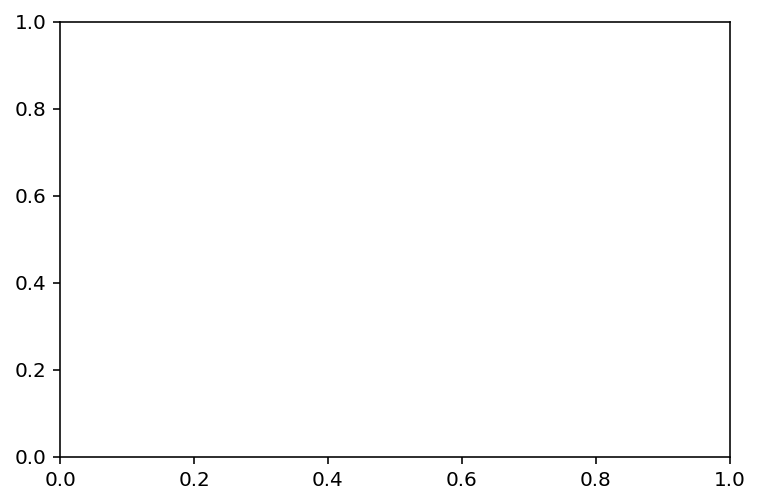

In [18]:
plt.figure()
plt.plot(ps,train_losses, label="Training set")
plt.plot(ps,test_losses, label="Test set")
plt.legend()
plt.title(r"Loss of a single learner with $\lambda=0.01$")
plt.ylabel("Loss")
plt.xlabel(r"Edge probability $p$")
plt.figure()
plt.plot(ps,train_accuracies, label="Training set")
plt.plot(ps,test_accuracies, label="Test set")
plt.legend()
plt.title(r"Accuracy of a single learner with $\lambda=0.01$")
plt.ylabel("Accuracy")
plt.xlabel(r"Edge probability $p$");

In [218]:
dataloaders, testloader, models = initialize_learners(100)
# Create optimizers to hold the state of one model
optimizers = [torch.optim.Adam(models[i].parameters()) for i in range(100)]

# Load batches infinitely in the same cycle (could update to resample a new loader after one epoch, but this is ok.)
dataiters = [cycle(dataloader) for dataloader in dataloaders]

In [261]:
# Kokeile rakennetuilla matriiseilla A
# Kokeile vain kahdella learnerillä
# Vertaa keskiarvooppijaan

0.06774333119392395

In [44]:
getAfromSBM(60,0.1,1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

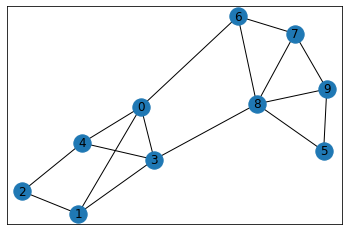

In [109]:
def get2AfromSBM(n1=10, n2=10, p_in=0.8
                 , p_out=0, mu_in=1, mu_out=1):
    n = [n1,n2]
    p = [[p_in, p_out], [p_out, p_in]]
    wt = [[np.random.normal,np.random.normal], [np.random.normal, np.random.normal]]
    wtargs = [[dict(loc=mu_in, scale=0), dict(loc=mu_out, scale=0)],
              [dict(loc=mu_out,scale=0), dict(loc=mu_in,  scale=0)]]
    A = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    return A

import networkx as nx
G = nx.from_numpy_matrix(get2AfromSBM(5,5,0.75,0.1,1))

fixedpos = {1:(0,0), 6:(4,4)}
pos = nx.spring_layout(G, fixed = fixedpos.keys(), pos = fixedpos)

nx.draw_networkx(G, pos=pos)

In [104]:
import numpy as np
from graspologic.simulations import sbm